# Capstone - Week 5

### Table of Contents ###

1. [Introduction/Business Problem](#Introduction)
2. [Data](#Data)
    - [Data Summary](#Data_Summary)
3. [Analysis](#Analysis)



<a id='Introduction'></a>
***

## Introduction/Business Problem

***

### Problem Description

In this project, we look for promising areas within the greater Melbourne metropolitan region in which to open a restaurant.

Factors include:
- Number of existing restaurants overall
- Number of existing restaurants of the same cuisine
- Income of residents in the area
- Age of residents in the area

Data sources:
- Wikipedia lists of cities and their suburbs
- Foursquare lists of restaurants in each vicinity
- Australian Bureau of Statistics (ABS) Census 2016

<a id='Data'></a>
***

## Data

***


In [1]:
from os import getenv

# Please replace CLIENT_ID and CLIENT_SECRET with your own FourSquare credentials to run FourSquare code.
CLIENT_ID = getenv('FOURSQR_ID')
CLIENT_SECRET = getenv('FOURSQR_SECRET')


### Data Acquisition - List of Suburbs

In [2]:
from urllib import request as req
from bs4 import BeautifulSoup as BS
from os import path
import pandas as pd
import re

# Look for local cache of wikipedia page; retrieve from the web if not found.
CACHE_PATH = 'cache'
if not path.exists(CACHE_PATH):
    print('Cache directory not found; Creating cache...', end=' ')
    os.mkdir(CACHE_PATH)
    print('Done!')
WIKIFILE_PATH = path.join(CACHE_PATH, 'wiki.cache')

soup = None
if path.exists(WIKIFILE_PATH):
    print('Found wiki in local cache; Loading wiki page from cache...', end=' ')
    with open(WIKIFILE_PATH, 'r') as wikif:
        wikitext = wikif.read()
        soup = BS(wikitext, 'html.parser')
        print('Done!')
else:
    print('Wiki local cache not found. Loading from URL instead...', end=' ')
    URL = 'https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs'
    wiki = req.urlopen(URL)
    wikitext = wiki.read().decode('utf-8')
    soup = BS(wikitext, 'html.parser')
    print('Done!')
    print('Writing wiki page to local cache...', end=' ')
    with open(WIKIFILE_PATH, 'w') as wikif:
        wikif.write(wikitext)
        print('Done!')
        
# remove Table of Contents
soup.find('div', class_='toc').decompose()
# remove all map thumbnail divs (they contain lists that interfere with extraction)
thumbs = soup.find_all('div', class_='thumb')
for t in thumbs:
    t.decompose()

test = soup.find_all('span', class_='mw-headline')


df_suburbs = pd.DataFrame(columns=['City', 'Suburb'])
# extract suburbs into dataframe
pattern = re.compile(r'^([a-zA-Z ]+)')
for t in test:
    if 'City of' in t.get_text() or 'Shire of' in t.get_text():
        city_name = t.get_text()
        ul = t.parent.findNext('ul')
        # remove all sub-areas (appears as second-level lists on the wikipedia page)
        for li in ul.find_all('li'):
            for child in li.contents:
                if child.name == 'ul':
                    child.decompose()
        # extract suburb names and corresponding postal codes
        for li in ul.find_all('li'):
            match = pattern.match(li.getText().rstrip())
            # print(f'suburb: {match.group(1)}, postcode: {match.group(2)}')
            try:
                df_suburbs.loc[df_suburbs.shape[0]] = [city_name, match.group(1).rstrip()]
            except:
                print(f'failed with:\n{li.getText().rstrip()}')

df_suburbs = df_suburbs.drop_duplicates(['Suburb']).reset_index(drop=True)
df_suburbs.tail()

Found wiki in local cache; Loading wiki page from cache...Done!
failed with:



,City,Suburb
372,City of Wyndham,Tarneit
373,City of Wyndham,Werribee
374,City of Wyndham,Werribee South
375,City of Wyndham,Williams Landing
376,City of Wyndham,Wyndham Vale


### Retrieve geolocations of each suburb.

In [3]:
from geopy.geocoders import Nominatim
from time import sleep

SUBURBS_PICKLE_PATH = path.join(CACHE_PATH, 'suburbs.pkl')
NOMI = Nominatim(user_agent='capstone')
POSTFIX = 'VIC, Australia'

def geocode(search_string):
    try:
        return NOMI.geocode(search_string)
    except:
        sleep(2)
        return geocode(search_string)

# import df_suburbs if local cache exists, else prepare df_suburbs for geocode population
if path.exists(SUBURBS_PICKLE_PATH):
    print('df_suburbs found locally; loading... ', end=' ')
    df_suburbs = pd.read_pickle(SUBURBS_PICKLE_PATH)
    print('Done!')
else:
    print('df_suburbs not found locally; prepping existing df_suburbs for geocode population... ', end=' ')
    df_suburbs['Latitude'] = [pd.np.nan for x in range(df_suburbs.shape[0])]
    df_suburbs['Longitude'] = [pd.np.nan for x in range(df_suburbs.shape[0])]

    print('Done!')

df_isna = df_suburbs[['Latitude', 'Longitude']].isna()

for i, row in df_suburbs.iterrows():
    suburb = row['Suburb']
    if df_isna.loc[i, 'Latitude'] == True or df_isna.loc[i, 'Longitude'] == True:
        print(f'Getting coordinates for {suburb}... ', end=' ')
        loc = geocode(f'{suburb} {POSTFIX}')
        df_suburbs.loc[i, 'Latitude'] = loc.latitude
        df_suburbs.loc[i, 'Longitude'] = loc.longitude
        print(f'Done! {df_suburbs.shape[0] - 1 - i} to go.')
        sleep(1)
    else:
        continue
        #print(f'Skipping {suburb}... ', end=" ")
    # Sleep for a second to avoid flooding geocoding host

df_suburbs.to_pickle(SUBURBS_PICKLE_PATH)
df_suburbs.head()

df_suburbs found locally; loading...  Done!


,City,Suburb,Latitude,Longitude
0,City of Melbourne,Carlton,-37.800423,144.968434
1,City of Melbourne,Carlton North,-37.784559,144.972855
2,City of Melbourne,Docklands,-37.817542,144.939492
3,City of Melbourne,East Melbourne,-37.812498,144.985885
4,City of Melbourne,Flemington,-37.786759,144.919367


In [4]:
import folium

MELB_ADDR = 'Melbourne, VIC, Australia'
loc = geocode(MELB_ADDR)
print(f'Geocode for {MELB_ADDR} is ({loc.latitude}, {loc.longitude})')

map_melbourne = folium.Map(location=[loc.latitude - 0.2, loc.longitude], zoom_start=9)

for i, row in df_suburbs.iterrows():
    label = row['Suburb']
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius = 3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_melbourne)

map_melbourne

Geocode for Melbourne, VIC, Australia is (-37.8142176, 144.9631608)


### Data Acquisition - FourSquare venues

Setting up FourSquare parameters

In [5]:
import json

VERSION = '20200101'

VDATA_PATH = 'venue_data'
if not path.exists(VDATA_PATH):
    os.mkdir(VDATA_PATH)

LIMIT = 50
RADIUS = 500
CATEGORY_ID = '4d4b7105d754a06374d81259' # food top-level category



Building comprehensive list of categories.

In [6]:
import gzip

CATS_LOCAL = 'categories.json'
cats = None

if path.isfile(CATS_LOCAL):
    print('Found local categories json. Loading...')
    with gzip.open(CATS_LOCAL, 'rt') as jsonfile:
        cats = json.load(jsonfile)
        print('Done!')
else:
    print('Local categories json not found. Loading from FourSquare...')
    cats_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION)
    results = json.load(req.urlopen(cats_url))
    cats = results['response']['categories']
    print('Writing loaded categories to local json...')
    with gzip.open(CATS_LOCAL, 'wt') as jsonfile:
        json.dump(cats, jsonfile)
        print('Done!')

food_cats = [x for x in cats if x['id'] == CATEGORY_ID]
def list_cats(cats, level=0):
    if level > 1:
        print('  ' * level, '...')
    else:
        for cat in cats:
            print('  ' * level, cat['name'])
            if len(cat['categories']) > 0:
                list_cats(cat['categories'], level + 1)
list_cats(food_cats)

Found local categories json. Loading...
Done!
 Food
   Afghan Restaurant
   African Restaurant
     ...
   American Restaurant
     ...
   Asian Restaurant
     ...
   Australian Restaurant
   Austrian Restaurant
   BBQ Joint
   Bagel Shop
   Bakery
   Bangladeshi Restaurant
   Belgian Restaurant
   Bistro
   Breakfast Spot
   Bubble Tea Shop
   Buffet
   Burger Joint
   Cafeteria
   Café
   Cajun / Creole Restaurant
   Caribbean Restaurant
     ...
   Caucasian Restaurant
   Coffee Shop
   Comfort Food Restaurant
   Creperie
   Czech Restaurant
   Deli / Bodega
   Dessert Shop
     ...
   Diner
   Donut Shop
   Dumpling Restaurant
   Dutch Restaurant
   Eastern European Restaurant
     ...
   English Restaurant
   Falafel Restaurant
   Fast Food Restaurant
   Fish & Chips Shop
   Fondue Restaurant
   Food Court
   Food Stand
   Food Truck
   French Restaurant
     ...
   Fried Chicken Joint
   Friterie
   Gastropub
   German Restaurant
     ...
   Gluten-free Restaurant
   Greek Resta

Retrieving venues in each suburb.

In [7]:
import gzip

VENUES_PATH = 'venue_data'
DEBUG = False
df_venues = pd.DataFrame()

for i, row in df_suburbs.iterrows():
    FILE_PATH = path.join(VENUES_PATH, row['Suburb'])
    results = None
    suburb = row['Suburb']
    if path.exists(FILE_PATH):
        if DEBUG: print(f'Found local file for {suburb}; Loading... ', end=' ')
        with gzip.open(FILE_PATH, 'rt') as infile:
            results = json.load(infile)
        if DEBUG: print('Done!')
    else:
        if DEBUG: print(f'Retrieving venues for {suburb}... ', end=' ')
        offset = 0
        lat = row['Latitude']
        lng = row['Longitude']
        url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={RADIUS}&limit={LIMIT}&offset={offset}&categoryId={CATEGORY_ID}'
        results = json.load(req.urlopen(url))
        if results['response']['totalResults'] > LIMIT:
            if DEBUG: print('Retrieving page 2... ', end=' ')
            offset = offset + LIMIT
            url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={RADIUS}&limit={LIMIT}&offset={offset}&categoryId={CATEGORY_ID}'
            res2 = json.load(req.urlopen(url))
            items1 = results['response']['groups'][0]['items']
            items2 = res2['response']['groups'][0]['items']
            results['response']['groups'][0]['items'] = items1 + items2
        if DEBUG: print('Done!')

        if DEBUG: print(f'Writing {suburb} venues to local file... ', end=' ')
        with gzip.open(FILE_PATH, 'wt') as outfile:
            json.dump(results, outfile)
        if DEBUG: print('Done!')

    df = pd.json_normalize(results['response']['groups'][0]['items'])
    if not df.empty:
        df = df[['venue.id', 'venue.name', 'venue.location.lat', 'venue.location.lng', 'venue.categories']]
        df.columns = ['ID', 'Name', 'Latitude', 'Longitude', 'Categories']
        df.insert(0, 'Suburb', suburb)
        df_venues = df_venues.append(df)

df_venues['Categories'] = [[y['name'] for y in x] for x in df_venues['Categories']]
df_venues['Categories'] = [''.join(x) for x in df_venues['Categories']]
df_venues.head()


,Suburb,ID,Name,Latitude,Longitude,Categories
0,Carlton,4b0b8439f964a520053223e3,D.O.C. Pizza & Mozzarella Bar,-37.798954,144.968490,Pizza Place
1,Carlton,4ea1fa3577c8d0ce5dc03a5d,Baker D. Chirico,-37.798788,144.968499,Bakery
2,Carlton,4b058750f964a520718b22e3,King & Godfree,-37.798574,144.967259,Deli / Bodega
3,Carlton,4b05874cf964a520dd8922e3,Shakahari,-37.798923,144.967830,Vegetarian / Vegan Restaurant
4,Carlton,4ba9fd41f964a520f4413ae3,Donnini's Restaurant,-37.799490,144.967231,Italian Restaurant


ABS datasets use codes to represent suburbs. A separate CSV contains the suburb codes and their respective suburb names. We will load this first:

In [8]:
DATA_PATH = 'data'

df_suburb_codes = pd.read_csv(path.join(DATA_PATH, 'SSC_2016_AUST.csv'))

# We only need Victoria suburbs...
df_suburb_codes = df_suburb_codes[df_suburb_codes['STATE_NAME_2016'] == 'Victoria']
# ...and only codes and names
df_suburb_codes = df_suburb_codes[['SSC_CODE_2016', 'SSC_NAME_2016']]
# Dropping duplicates
df_suburb_codes.drop_duplicates(ignore_index=True, inplace=True)

# Removing parantheses text (that was used to differentiate same suburb names in different states)
exp = re.compile(r'^([\w\W]+)\([\w\s\W]+\)')
df_suburb_codes['SSC_NAME_2016'] = [x if exp.match(x) == None else exp.match(x).group(1).rstrip() for x in df_suburb_codes['SSC_NAME_2016']]

# Converting int codes to strings for later corelation
df_suburb_codes['SSC_CODE_2016'] = [str(x) for x in df_suburb_codes['SSC_CODE_2016']]
df_suburb_codes.head()

,SSC_CODE_2016,SSC_NAME_2016
0,20022,Alfredton
1,20483,Cardigan Village
2,20482,Cardigan
3,21540,Lucas
4,21426,Lake Gardens


**Importing ABS age data.**

In [9]:
df_ages_A = pd.read_csv(path.join(DATA_PATH, '2016Census_G04A_VIC_SSC.csv'))
df_ages_B = pd.read_csv(path.join(DATA_PATH, '2016Census_G04B_VIC_SSC.csv'))
df_ages = df_ages_A.set_index('SSC_CODE_2016').join(df_ages_B.set_index('SSC_CODE_2016'))
df_ages.tail()

,Age_yr_0_M,Age_yr_0_F,Age_yr_0_P,Age_yr_1_M,Age_yr_1_F,Age_yr_1_P,Age_yr_2_M,Age_yr_2_F,Age_yr_2_P,Age_yr_3_M,...,Age_yr_90_94_P,Age_yr_95_99_M,Age_yr_95_99_F,Age_yr_95_99_P,Age_yr_100_yr_over_M,Age_yr_100_yr_over_F,Age_yr_100_yr_over_P,Tot_M,Tot_F,Tot_P
SSC_CODE_2016,,,,,,,,,,,,,,,,,,,,,
SSC22927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16,17,37
SSC22928,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,81,66,149
SSC22929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SSC29494,55,36,94,38,43,80,32,26,62,51,...,8,0,3,3,0,0,0,4331,3238,7565
SSC29797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,28,4,29


Age data columns are categorized M (male), F (female), and P (Person).

We will only be looking at P.

In [10]:
# retaining all Ps
exp = re.compile(r'[\w\W]+P$')
df_ages_P = df_ages.loc[:, [x for x in df_ages.columns if exp.match(x) != None]]
# renaming columns to age
exp = re.compile(r'[\w_]*_([\w]+)_P$')
df_ages_P.columns = [x if exp.match(x) == None else exp.match(x).group(1) for x in df_ages_P.columns]
# drop Total column
df_ages_P.drop('Tot_P', axis='columns', inplace=True)
df_ages_P.head()

,0,1,2,3,4,4,5,6,7,8,...,76,77,78,79,79,84,89,94,99,over
SSC_CODE_2016,,,,,,,,,,,,,,,,,,,,,
SSC20001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SSC20002,86,82,44,57,44,319,33,40,34,33,...,17,21,12,15,93,91,62,28,14,0
SSC20003,34,30,41,30,50,179,40,47,59,55,...,9,17,4,18,74,57,57,26,8,0
SSC20004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SSC20005,0,0,0,0,0,0,0,0,0,3,...,0,0,3,4,6,5,4,0,0,0


We will be looking at 4 different age groups representative of potential customer types:
 - 0-15 (dependent children)
 - 16-27 (young adults)
 - 28-55 (adults)
 - 56 and older (retirees)

In [11]:
df_age_groups = pd.DataFrame(index=df_ages_P.index)
# 0-15
df_age_groups['0-15'] = df_ages_P[[str(x) for x in range(16)]].sum(axis=1)
# 16-27
df_age_groups['16-27'] = df_ages_P[[str(x) for x in range(16, 28)]].sum(axis=1)
# 28-55
df_age_groups['28-55'] = df_ages_P[[str(x) for x in range(28, 56)]].sum(axis=1)
# 56 and older
df_age_groups['56 and older'] = df_ages_P[[col for col in df_ages_P.columns if col not in [str(x) for x in range(0, 56)]]].sum(axis=1)

df_age_groups.head()

,0-15,16-27,28-55,56 and older
SSC_CODE_2016,,,,
SSC20001,0,0,0,0
SSC20002,1310,2883,9591,3682
SSC20003,1521,1330,3053,2745
SSC20004,0,0,0,0
SSC20005,52,20,70,259


**Adding suburb names to the age groups table.**

In [12]:
# Removing prefix 'SSC' from suburb codes in age groups table
exp = re.compile(r'SSC([\w]+)$')
df_age_groups.index = [exp.match(x).group(1) for x in df_age_groups.index]

df_suburb_names = df_suburb_codes.set_index('SSC_CODE_2016')
df_age_groups = df_age_groups.join(df_suburb_names)

df_age_groups.sort_values(by='28-55', ascending=False).head()

,0-15,16-27,28-55,56 and older,SSC_NAME_2016
22074,28621,11586,49302,15870,Point Cook
20657,26988,15603,45539,19182,Craigieburn
22149,16806,13415,43739,36230,Reservoir
21629,3645,39623,42318,13404,Melbourne
20223,22227,13855,38578,29724,Berwick


**Importing ABS income data.**

We will be looking at a rough gauge of **disposable income** levels, which will be calculated by subtracting _median mortgage repayments_ from _median household income_.

In [13]:
df_income = pd.read_csv(path.join(DATA_PATH, '2016Census_G02_VIC_SSC.csv'))
df_income.set_index('SSC_CODE_2016', inplace=True)
exp = re.compile(r'SSC([\w]+)$')
df_income.index = [exp.match(x).group(1) for x in df_income.index]

df_suburb_names = df_suburb_codes.set_index('SSC_CODE_2016')
df_income = df_income[['Median_mortgage_repay_monthly', 'Median_tot_hhd_inc_weekly']]
df_income = df_income.join(df_suburb_names)
df_income.head()

,Median_mortgage_repay_monthly,Median_tot_hhd_inc_weekly,SSC_NAME_2016
20001,0,0,Abbeyard
20002,2142,2001,Abbotsford
20003,2200,2200,Aberfeldie
20004,0,0,Aberfeldy
20005,1424,1109,Acheron


Calculate disposable income and clean table up.

In [14]:
df_income_disp = df_income.loc[:]
df_income_disp['Median_inc_monthly'] = df_income_disp['Median_tot_hhd_inc_weekly'] * 52.143 / 12
df_income_disp['Disposable income monthly'] = df_income_disp['Median_inc_monthly'] - df_income_disp['Median_mortgage_repay_monthly']
df_income_disp.drop(['Median_mortgage_repay_monthly', 'Median_tot_hhd_inc_weekly', 'Median_inc_monthly'], axis=1, inplace=True)
df_income_disp = df_income_disp.dropna()[df_income_disp['Disposable income monthly'] != 0]
df_income_disp.head()

,SSC_NAME_2016,Disposable income monthly
20002,Abbotsford,6552.84525
20003,Aberfeldie,7359.55000
20005,Acheron,3394.88225
20007,Adams Estate,2953.64225
20008,Addington,1881.08050


<a id='Data_Summary'></a>

## Data Summary

We now have dataframes for the following:

1. Suburbs and their geolocation
2. Foursquare "food" venues around the suburb geolocations
3. Suburb resident age group sizes
4. Suburb median household disposable income

#### 1. Suburbs:

In [15]:
df_suburbs.sample(n=5)

,City,Suburb,Latitude,Longitude
152,City of Manningham,Warrandyte,-37.758597,145.227628
193,Shire of Yarra Ranges,Montrose,-37.810625,145.342151
150,City of Manningham,Templestowe,-37.754059,145.148615
143,City of Knox,Wantirna,-37.852336,145.225972
136,City of Knox,Knoxfield,-37.889773,145.249634


#### 2. Foursquare data

In [16]:
df_venues.sample(n=5)

,Suburb,ID,Name,Latitude,Longitude,Categories
0,Keilor Lodge,4c89c5122e333704ce0ebe41,Sumos Noodle & Sushi Bar,-37.702024,144.800591,Sushi Restaurant
42,Footscray,4bbd113f4e069c745a519ee3,Breadtop,-37.799710,144.900250,Bakery
2,Cheltenham,4b7c9706f964a5209c9c2fe3,Cinnamon Club,-37.964850,145.057710,Indian Restaurant
26,South Melbourne,5653bee8498e224bfab2de08,Wings of Glory,-37.832248,144.960267,Fried Chicken Joint
14,Brunswick,5679cc72498e38ab1d10aa85,Kines,-37.763898,144.961127,Café


#### 3. Suburb residents age groups

In [17]:
df_age_groups.sample(n=5)

,0-15,16-27,28-55,56 and older,SSC_NAME_2016
22714,721,676,1358,1703,Wattle Glen
22898,615,357,1169,1742,Yarragon
20317,40,6,36,22,Bradvale
21991,11,0,9,0,Oakvale
20242,0,0,0,0,Bingo Munjie


#### 4. Suburb median household disposable income

In [18]:
df_income_disp.sample(n=5)

,SSC_NAME_2016,Disposable income monthly
22561,Trawool,4635.13750
20568,Clear Lake,3739.40525
21420,Lake Bunga,2962.95275
20177,Bearii,2477.08050
21583,Manifold Heights,4465.90975


<a id='Analysis'></a>
---

## Exploratory Data Analysis ##

---

In [19]:
from matplotlib import pyplot as plt

### Looking at income and mortages.

In [20]:
df_highest_incdisp = df_suburbs.set_index('Suburb').join(df_income_disp.set_index('SSC_NAME_2016')).sort_values(by='Disposable income monthly', ascending=False)
df_highest_incdisp = df_highest_incdisp.dropna()
df_highest_incdisp = df_highest_incdisp.reset_index().rename({'index': 'Suburb'}, axis='columns')
df_highest_incdisp

,Suburb,City,Latitude,Longitude,Disposable income monthly
0,South Wharf,City of Melbourne,-37.825328,144.949343,11372.06250
1,Warrandyte South,City of Manningham,-37.761003,145.237385,9782.43750
2,Park Orchards,City of Manningham,-37.776919,145.214621,9158.36500
3,Plenty,Shire of Nillumbik,-37.667450,145.112377,9078.50700
4,Kooyong,City of Stonnington,-37.841394,145.035840,8906.28125
...,...,...,...,...,...
353,Campbellfield,City of Hume,-37.664130,144.959583,2501.97525
354,Braeside,City of Kingston,-38.000524,145.122958,2494.17350
355,Junction Village,City of Casey,-38.136344,145.296870,2483.80875
356,Heidelberg West,City of Banyule,-37.738243,145.043392,2463.24900


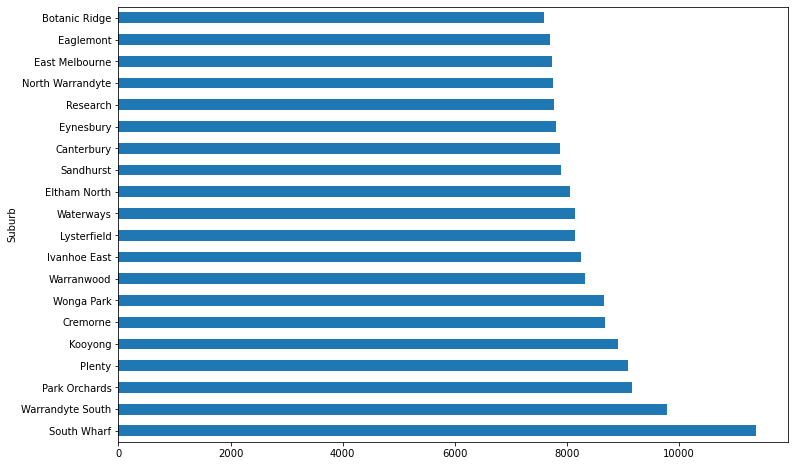

In [21]:
df_highest_incdisp.head(20).set_index('Suburb')['Disposable income monthly'].plot.barh(figsize=(12, 8))

Let's see which cities these top disposable income suburbs are in.

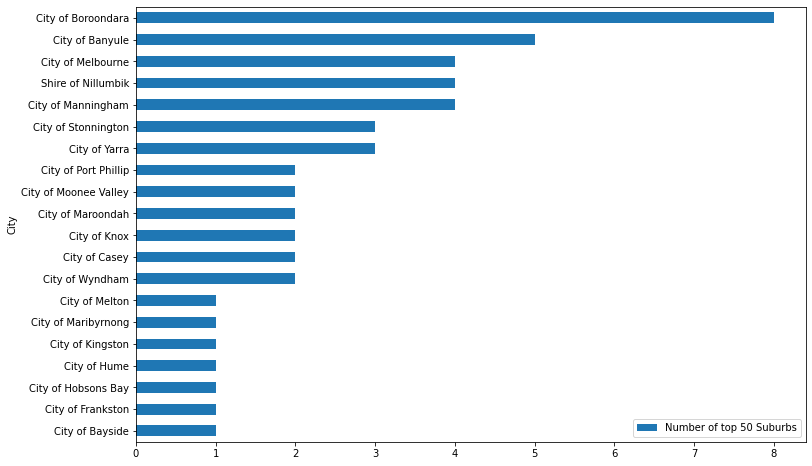

In [22]:
df_highest_incdisp.head(50).groupby('City')['City'].count().to_frame(name='Number of top 50 Suburbs').sort_values('Number of top 50 Suburbs').plot.barh(figsize=(12, 8))


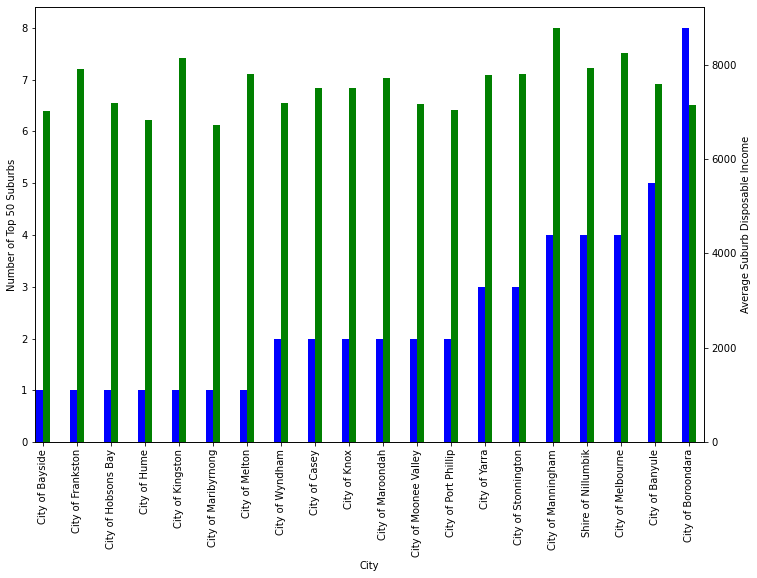

In [23]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_fig = df_highest_incdisp.head(50).groupby('City').agg(
    suburb_count=pd.NamedAgg(column='Suburb', aggfunc='count'),
    avg_disp_income=pd.NamedAgg(column='Disposable income monthly', aggfunc='mean')
    ).sort_values(by='suburb_count')

barwidth = 0.2

df_fig['suburb_count'].plot(kind='bar', color='blue', ax=ax, position=1, width=barwidth)
df_fig['avg_disp_income'].plot(kind='bar', color='green', ax=ax2, position=0, width=barwidth)

ax.set_ylabel('Number of Top 50 Suburbs')
ax2.set_ylabel('Average Suburb Disposable Income')

plt.show()


### Looking at FourSquare venue data.

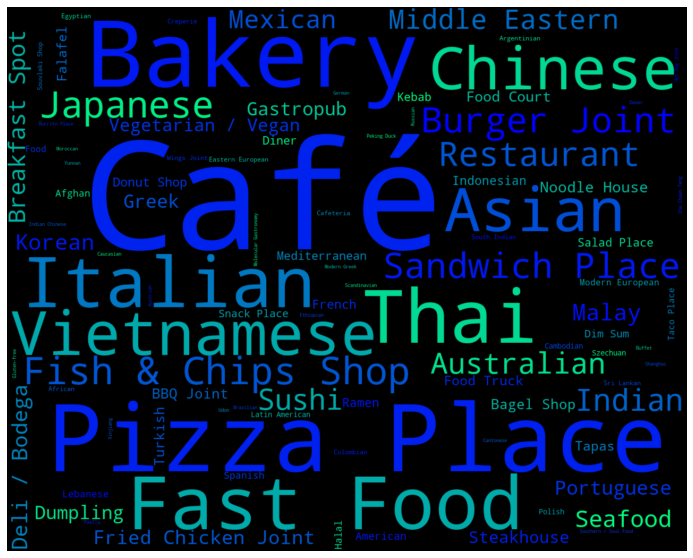

In [24]:
from wordcloud import WordCloud

df_venues_catcount = df_venues.groupby('Categories').count()['ID']

catcount_dict = df_venues_catcount.rename({x: x.replace(' Restaurant', '') for x in df_venues_catcount.index}).to_dict()

wc = WordCloud(width=1280, height=1024, colormap='winter', max_words=9999).generate_from_frequencies(catcount_dict)

plt.figure(figsize=(14, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

As is evident from the above word cloud, the most common restaurants in greater Melbourne are Pizzarias, Thai restaurants, Fast Food restaurants, and Italian restaurants.

Next, we'll explore category frequencies in the 10 cities with the highest disposable incomes.

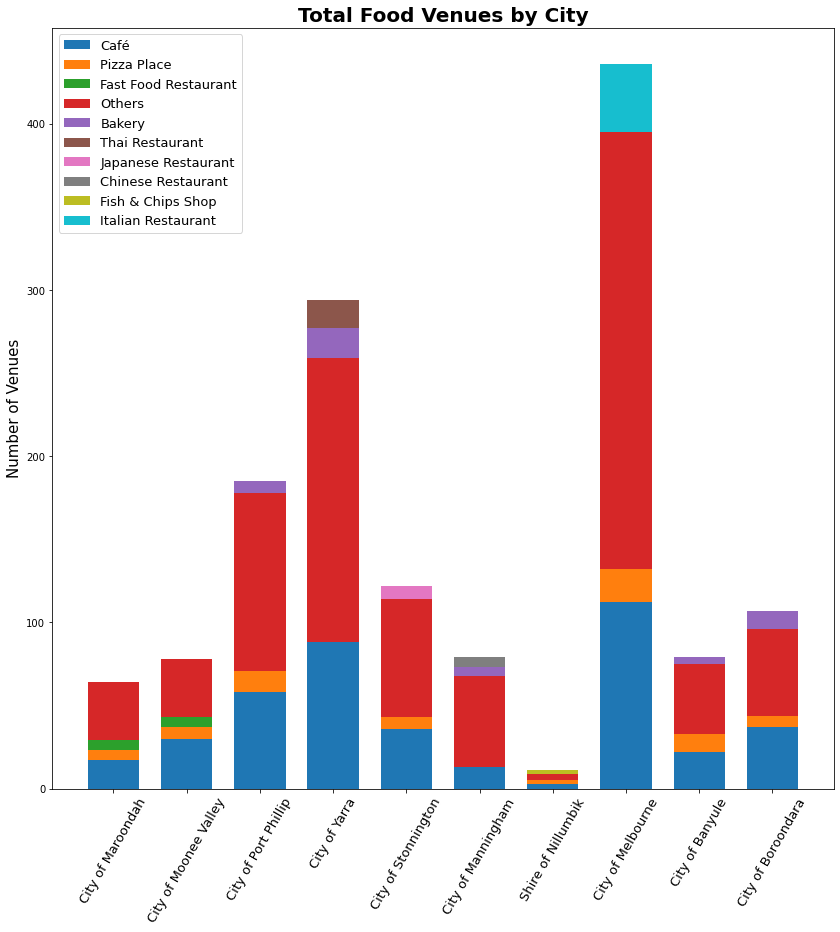

In [25]:
import numpy as np

top10_cities = [x for x in df_fig.tail(10).index]

top10_cities_subs = df_suburbs.loc[df_suburbs['City'].isin(top10_cities), 'Suburb'].unique()

city_venues = {x: {} for x in top10_cities}

for city in city_venues:
    suburbs = df_suburbs.loc[df_suburbs['City'] == city]
    suburbs = suburbs['Suburb'].tolist()
    venues = df_venues.loc[df_venues['Suburb'].isin(suburbs)]
    venues = venues.groupby('Categories').size().to_dict()
    city_venues[city] = venues

city_venues_df = pd.DataFrame(city_venues)

cities_Ncat_dict = {}

for city in top10_cities:
    city_Ncat = city_venues_df[city].sort_values(ascending=False)
    cities_Ncat_dict[city] = {}
    # get top 3 categories
    n = 3
    index = city_Ncat.index
    for i in range(n):
        cities_Ncat_dict[city][index[i]] = city_Ncat.iloc[i]
    # get others tally
    cities_Ncat_dict[city]['Others'] = city_Ncat.iloc[n:].sum()

city_top_venues_df = pd.DataFrame(cities_Ncat_dict)

N = len(top10_cities)
ind = np.arange(N)
width = 0.7

prev = None
plt.figure(figsize=(14, 14))
levels = []
for i, row in city_top_venues_df.iterrows():
    row = row.fillna(0)
    levels.append(plt.bar(ind, row.tolist(), width, bottom=prev))
    prev = row.tolist() if prev == None else [x + y for (x, y) in zip(prev, row.tolist())]

plt.title('Total Food Venues by City', fontsize=20, fontweight='bold')
plt.ylabel('Number of Venues', fontsize=15)
plt.xticks(ind, top10_cities, rotation=60, fontsize=13)
plt.legend(levels, city_top_venues_df.index, fontsize=13)
plt.show()

Observations from the above chart:
- Cafés are ubiquitous
- There is a distinct lack of Pizzarias in the Cities of Yarra and Manningham

As Pizzarias are about as ubiquitous as Cafés, it could be argued that there would always be demand for pizza. A Pizzaria in the City of Yarra or the City of Manningham would also have reduced competition.

Let's have a closer look at other options by discounting the most common categories of eateries.

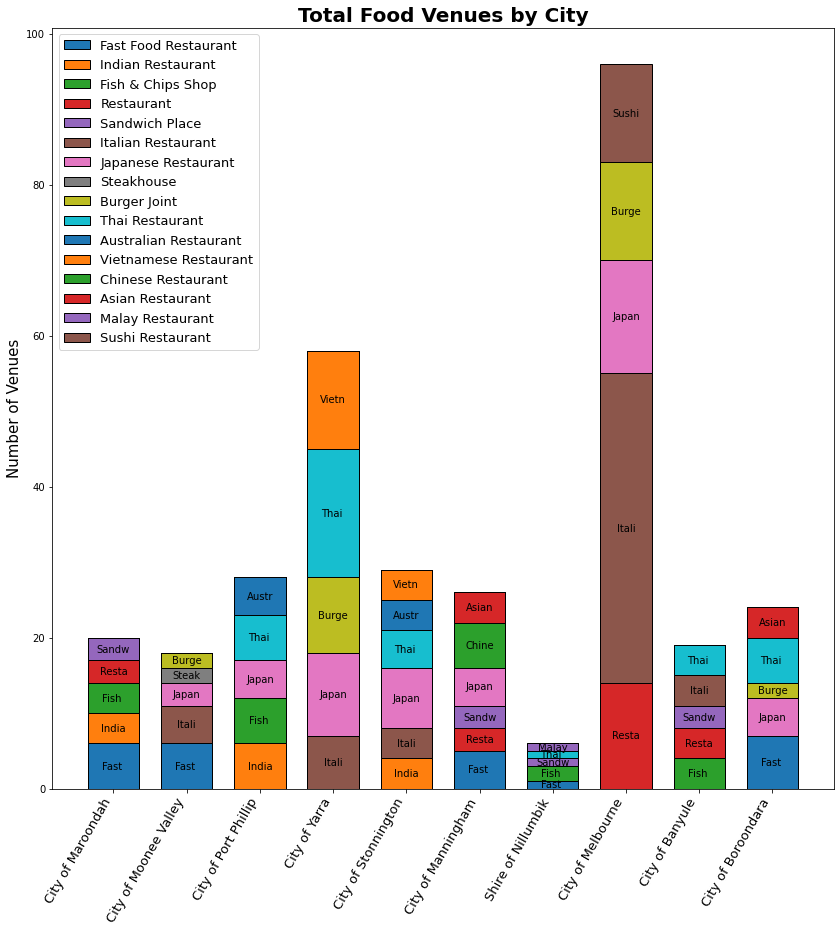

In [26]:
for city in top10_cities:
    city_Ncat = city_venues_df[city].sort_values(ascending=False)
    cities_Ncat_dict[city] = {}
    # get top 3 categories
    n = 8
    index = city_Ncat.index
    for i in range(n):
        cities_Ncat_dict[city][index[i]] = city_Ncat.iloc[i]
    # get others tally
    cities_Ncat_dict[city]['Others'] = city_Ncat.iloc[n:].sum()

drop_cats = ['Café', 'Others', 'Bakery', 'Pizza Place']
city_top_venues_df = pd.DataFrame(cities_Ncat_dict)
city_top_excl_df = city_top_venues_df.drop(drop_cats)

prev = None
plt.figure(figsize=(14, 14))
levels = []
for i, row in city_top_excl_df.iterrows():
    row = row.fillna(0)
    bars = plt.bar(ind, row.tolist(), width, bottom=prev, edgecolor='black')
    levels.append(bars)
    for b in bars:
        if (b.get_height() > 0):
            plt.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() / 2, i[0:5], va='center', ha='center')
    prev = row.tolist() if prev == None else [x + y for (x, y) in zip(prev, row.tolist())]

plt.title('Total Food Venues by City', fontsize=20, fontweight='bold')
plt.ylabel('Number of Venues', fontsize=15)
plt.xticks(ind, top10_cities, rotation=60, fontsize=13, ha='right', x=2000)
plt.legend(levels, city_top_excl_df.index, fontsize=13)
plt.show()

From the above chart, we can make the following observations about each City:

1. Common categories - Opening a restaurant in these categories may guarantee some patronage as demand has already been established in these areas. However, it may be more challenging to beat the competition for larger patronage.

2. Rare/Non-existent categories - Opening a restaurant in these categories is risky as demand for these in the area is relatively unknown. However, if demand turns out to be high, there will be little if any competition.  

### Looking at age groups:

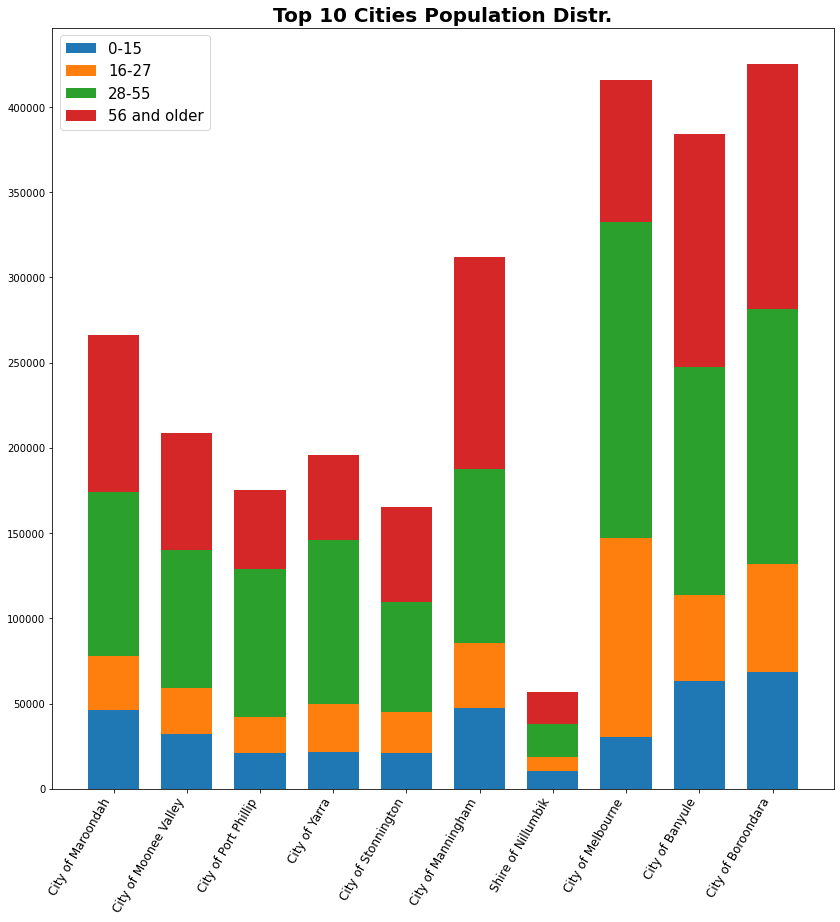

In [27]:
city_age_groups = {}

for city in top10_cities:
    suburb_list = df_suburbs[df_suburbs['City'] == city]['Suburb'].tolist()
    city_age_groups[city] = df_age_groups[ df_age_groups['SSC_NAME_2016'].isin(suburb_list) ] \
        .drop('SSC_NAME_2016', axis=1) \
        .sum() \
        .to_dict()
    
city_age_groups_df = pd.DataFrame(city_age_groups)

plt.figure(figsize=(14, 14))

prev = None
levels = []
width = 0.7
ind = range(len(top10_cities))
for i, row in city_age_groups_df.iterrows():
    levels.append(plt.bar(ind, row.to_list(), width, bottom=prev))
    prev = row.to_list() if prev == None else [x + y for (x, y) in zip(prev, row.to_list())]

plt.title('Top 10 Cities Population Distr.', fontsize=20, weight='bold')
plt.xticks(ind, top10_cities, rotation=60, ha='right', fontsize=12)
plt.legend(levels, city_age_groups_df.index, fontsize=15)
plt.show()

The above chart gives us an idea of the potential customer pools of each city. It also gives us a rough gauge of the age-group distribution of each city.

For example, we can see that Melbourne, Banyule and Boroondara have relatively large potential customer pools. However, from the previous chart, we can tell that Banyule and Boroondara have a relatively low concentration of restaurants. This hints at a possible deficit in supply relative to demand in these two cities.

Next, we'll look at the same stacked bar chart normalized, so we can get a clearer idea of differing age group proportions of each city.

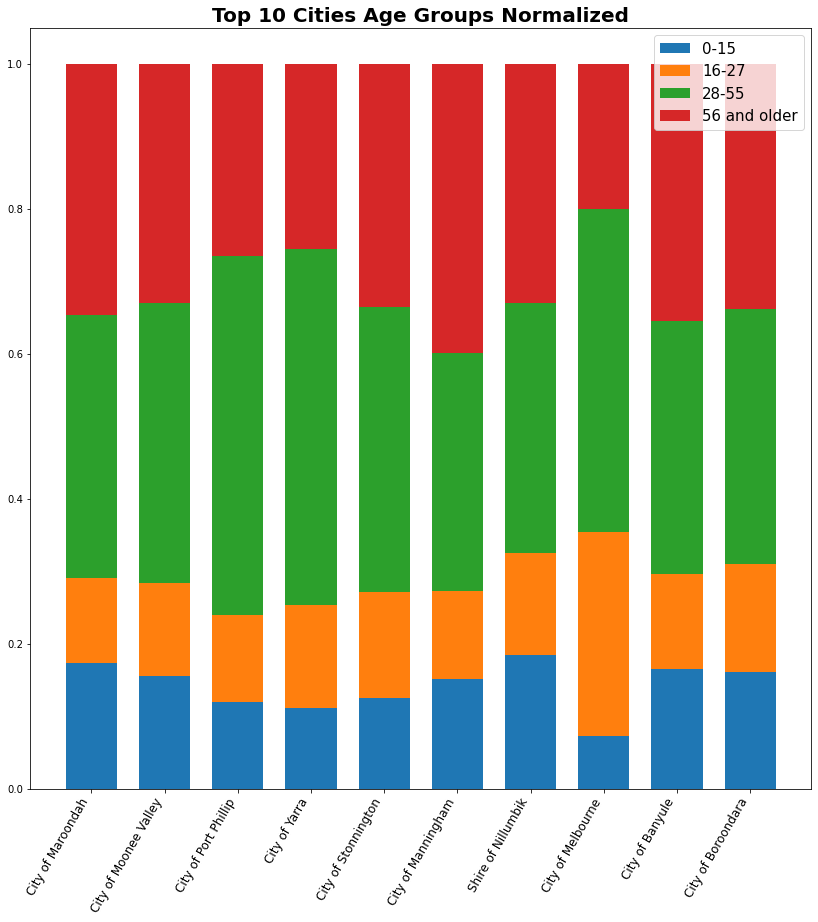

In [28]:
plt.figure(figsize=(14, 14))
prev = None
levels = []
ind = range(len(top10_cities))
totals = city_age_groups_df.sum()
for i, row in city_age_groups_df.iterrows():
    percentages = [x/y for (x, y) in zip(row, totals)]
    levels.append(plt.bar(ind, percentages, width, bottom=prev))
    prev = percentages if prev == None else [x + y for (x, y) in zip(prev, percentages)]

plt.title('Top 10 Cities Age Groups Normalized', fontsize=20, fontweight='bold')
plt.xticks(ind, city_age_groups_df.columns, fontsize=12, rotation=60, ha='right')
plt.legend(levels, city_age_groups_df.index, fontsize=15)
plt.show()

Age groups are something to consider when planning a restaurant's menu or designing its ambience.

We look at 4 age groups:

1. 0-15: A large proportion of 0-15 year-olds in the local population suggests that most households in the area are families with dependent children.

2. 16-27: This age group represents indepent young adults who have just found their independence. They may be more likely to eat alone or with friends, but perhaps have less spending power than older adults.

3. 28-55: Adults who are more likely to have settled down are also more likely to have predictable patterns in their day-to-day lives, and perhaps also tastes.

4. 56 and above: Retirees tend to like spending more time lounging in peace at cafes.

### Finding Similar Cities

The following data will be put through the KMeans algorithm to find clusters of similar suburbs:
- Age groups as proportions of each city's total population
- Numbers of each type of restaurants in each city

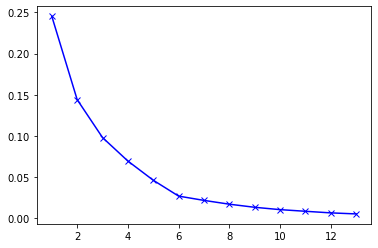

[0.24532604228145458, 0.14407011697287198, 0.09798720866161711, 0.06944994335302787, 0.04615165469671714, 0.02686320248488757, 0.021652958738840072, 0.017039415018823018, 0.013270544596207117, 0.010433161412325063, 0.008430498796031347, 0.0064889866829919846, 0.005231945687148127]


,0-15,16-27,28-55,56 and older,Cluster
City,,,,,
City of Hume,0.207968,0.146461,0.373356,0.272215,0
City of Bayside,0.170943,0.110983,0.291816,0.426258,0
City of Casey,0.213487,0.140484,0.381157,0.264871,0
Shire of Cardinia,0.227372,0.133365,0.379306,0.259957,0
City of Whittlesea,0.202141,0.129179,0.389677,0.279003,0
City of Boroondara,0.161498,0.148896,0.351030,0.338576,1
City of Brimbank,0.174154,0.141300,0.368071,0.316474,1
City of Monash,0.147357,0.166475,0.347749,0.338419,1
City of Glen Eira,0.169192,0.130129,0.381611,0.319069,1


In [59]:
df_ag = df_age_groups.rename(columns={'SSC_NAME_2016': 'Suburb'})
df_ag = pd.merge(df_suburbs, df_ag, on='Suburb')
df_ag = df_ag.loc[:, ['City', '0-15', '16-27', '28-55', '56 and older']]
df_ag = df_ag.groupby(by='City').sum()
df_ag_norm = df_ag.loc[:].astype('float')

for i, row in df_ag_norm.iterrows():
    total = row.sum()
    for j, col in row.iteritems():
        row[j] = col / total

df_ag_norm.head()

from sklearn.cluster import KMeans

# find optimal k
K = range(1, 14)
inertias = []
for k in K:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
    k_means.fit(df_ag_norm)
    k_means.labels_

    df_ag_clustered = df_ag_norm
    df_ag_clustered['Cluster'] = k_means.labels_
    df_ag_clustered.sort_values(by='Cluster')
    inertias.append(k_means.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel = 'k'
plt.ylabel = 'Sum of squared distances'
plt.show()
print(inertias)

# k = 5
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)
k_means.fit(df_ag_norm)
k_means.labels_

df_ag_clustered = df_ag_norm
df_ag_clustered['Cluster'] = k_means.labels_
df_ag_clustered.sort_values(by='Cluster')



3
1
2
0
4


ValueError: Each row in 'cellText' must have 9 columns

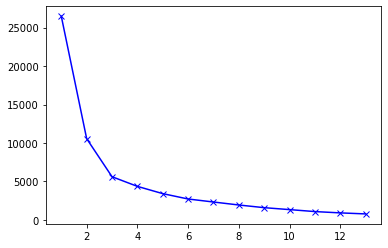

[26481.935483870962, 10558.75, 5605.773809523809, 4350.044444444445, 3405.8888888888887, 2707.3333333333335, 2315.4833333333336, 1926.9761904761904, 1579.1999999999998, 1326.8035714285716, 1070.720238095238, 900.5535714285714, 766.8249999999999]


,Cluster
City,
City of Banyule,0
Shire of Mornington Peninsula,0
Shire of Cardinia,0
City of Wyndham,0
City of Whittlesea,0
City of Whitehorse,0
City of Monash,0
City of Melton,0
Shire of Nillumbik,0


In [60]:
df_venues_city = pd.merge(df_venues, df_suburbs, on='Suburb')
df_venues_city = df_venues_city.loc[:, ['City', 'Categories']]
df_ohot = pd.get_dummies(df_venues_city['Categories'])
df_ohot.insert(0, 'City', df_venues_city['City'])
df_ohot = df_ohot.groupby(by='City').sum()
df_ohot

# find optimal k
K = range(1, 14)
inertias = []
for k in K:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)

    k_means.fit(df_ohot)
    # df_venues_clustered = df_ohot
    # df_venues_clustered.drop(df_venues_clustered.columns, axis=1, inplace=True)
    # df_venues_clustered['Cluster'] = k_means.labels_
    # df_venues_clustered.sort_values(by='Cluster')
    inertias.append(k_means.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel = 'k'
plt.ylabel = 'Sum of squared distances'
plt.show()
print(inertias)

# k = 3
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)

k_means.fit(df_ohot)
df_venues_clustered = df_ohot
df_venues_clustered.drop(df_venues_clustered.columns, axis=1, inplace=True)
df_venues_clustered['Cluster'] = k_means.labels_
df_venues_clustered.sort_values(by='Cluster')
